# Real or Not? NLP with Disaster Tweets

# Introduction 

The **goal of this Kaggle competition** is to predict whether a tweet is a disaster or not - a typical binary classification problem for textual data. 

Therefore, we will need to create accurate ML models and keep the one which has the highest test accuracy. The main measure will be the F1 score as it's a mix between precision and recall measures. 



**Link to Github repository:** https://github.com/rnaua/BSA2020_project2

**Link to Youtube video:** https://www.youtube.com/watch?v=2EsTC1vKSJo&feature=youtu.be

**Link to Kaggle competition:** https://www.kaggle.com/c/nlp-getting-started

# Importing libraries and modules

The following modules and libraries will help us to clean, analyze and visualize the data as well as create various ML models. 

In [0]:
!pip install tqdm

In [0]:

# import libraries 
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt

import tensorflow_hub as hub
from tqdm import tqdm
import tensorflow as tf
from tensorflow.python.keras.layers import Input, Dense

import re
from xgboost import XGBClassifier
from wordcloud import WordCloud

import nltk
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import sent_tokenize, word_tokenize

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

import string
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LogisticRegression,SGDClassifier, LinearRegression, LogisticRegressionCV
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.svm import SVC, NuSVC
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import VotingClassifier

from sklearn.model_selection import cross_val_score

from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from warnings import filterwarnings

from google.colab import files

from keras.layers import Dense, Conv1D, MaxPool1D, Flatten, Dropout, Embedding, LSTM
from keras.models import Sequential
from keras.utils import to_categorical


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


# Loading and exploring data

In order to predict whether a tweet is a disaster or not, we've been given 2 main datasets by Kaggle: train and test. 

In [0]:
# load data
train = pd.read_csv('https://raw.githubusercontent.com/rnaua/BSA2020_project2/master/train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/rnaua/BSA2020_project2/master/test.csv')
submission = pd.read_csv('https://raw.githubusercontent.com/rnaua/BSA2020_project2/master/sample_submission.csv')

### Exploring the train set

The train set has a "target" column containing only 1 and 0. In other words, it says if it's a disaster (1) or not (0). 


In [0]:
train.tail()

,id,keyword,location,text,target
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1


In [0]:
# example of a disaster tweet
print("Example of a disaster tweet: ",train[train["target"] == 1]["text"].values[123])

# example of a non-disaster tweet
print("Example of a non-disaster tweet: ", train[train["target"] == 0]["text"].values[3])

Example of a disaster tweet:  ohH NO FUKURODANI DIDN'T SURVIVE THE APOCALYPSE BOKUTO FEELS HORRIBLE  my poor boy my ppor child
Example of a non-disaster tweet:  My car is so fast


Hopefully, there are less non-disaster tweets than disasters in this train set.

In [0]:
train[["id","target"]].groupby(["target"]).count()

,id
target,
0,4342
1,3271


[Text(0, 0.5, 'Count'), Text(0.5, 0, 'Is a real disaster ?')]

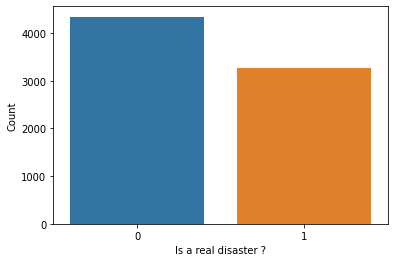

In [0]:
graph = sns.countplot(train.target)
graph.set(xlabel="Is a real disaster ?", ylabel = "Count")

### Exploring the test set


The test set, which does not contain the "target" column, is our second playground. 

We have to predict whether those tweets are a disaster or not based on our training model for the train set. 

In [0]:
test.tail()

,id,keyword,location,text
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...
3262,10875,NaN,NaN,#CityofCalgary has activated its Municipal Eme...


# Cleaning data

Because we've also seen that many abbreviations are in the "text" column of both sets, we will replace them by the original words. 

In [0]:
# Thanks to https://www.kaggle.com/rftexas/text-only-kfold-bert

abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

# define functions for convertion
def convert_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

def convert_abbrev_in_text(text):
    tokens = word_tokenize(text)
    tokens = [convert_abbrev(word) for word in tokens]
    text = ' '.join(tokens)
    return text


We've seen that the column "text" from both sets contains lots of noise information, such as url, emojis, numbers...  We will clean both datasets by removing them.

In [0]:
# define functions for removing noises from text
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
  
def remove_numbers(text):
    text = ''.join([i for i in text if not i.isdigit()])         
    return text 

def remove_punct(text):
    table = str.maketrans('','',string.punctuation)
    return text.translate(table)

stop = set(stopwords.words('english'))
def remove_stop_words(text):
    word_tokens = word_tokenize(text) 
    filtered_sentence = [w for w in word_tokens if not w in stop] 
    filtered_tweet = ' '.join(filtered_sentence)
    return filtered_tweet

def clean(text):
  remove_numbers(text)
  remove_url(text)
  remove_html(text)
  remove_emoji(text)
  remove_punct(text)
  remove_stop_words(text)
  convert_abbrev_in_text(text)

In [0]:
# apply cleaning function on the text
train_cleaned = train
test_cleaned = test
train_cleaned['text']=train_cleaned['text'].apply(lambda x : remove_stop_words(x))
train_cleaned['text']=train_cleaned['text'].apply(lambda x : remove_punct(x))
train_cleaned['text']=train_cleaned['text'].apply(lambda x : remove_numbers(x))
train_cleaned['text']=train_cleaned['text'].apply(lambda x : remove_html(x))
train_cleaned['text']=train_cleaned['text'].apply(lambda x : remove_emoji(x))
train_cleaned['text']=train_cleaned['text'].apply(lambda x : convert_abbrev_in_text(x))

test_cleaned['text']=test_cleaned['text'].apply(lambda x : remove_stop_words(x))
test_cleaned['text']=test_cleaned['text'].apply(lambda x : remove_punct(x))
test_cleaned['text']=test_cleaned['text'].apply(lambda x : remove_numbers(x))
test_cleaned['text']=test_cleaned['text'].apply(lambda x : remove_html(x))
test_cleaned['text']=test_cleaned['text'].apply(lambda x : remove_emoji(x))
test_cleaned['text']=test_cleaned['text'].apply(lambda x : convert_abbrev_in_text(x))

# Visualising data

We will start by doing a simple word cloud for each data set to see if some words are frequent in both the disaster and non-disaster setting.

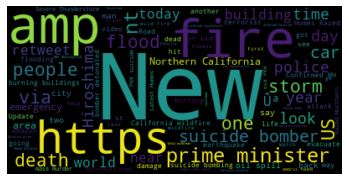

In [0]:
disaster = ' '.join([text for text in train_cleaned['text'][train_cleaned['target']==1]])
wordcloud = WordCloud(max_font_size=110).generate(disaster)
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis('off')
plt.show()

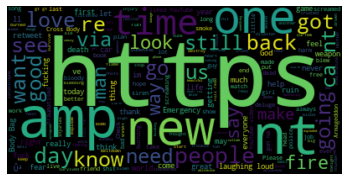

In [0]:
nondisaster = ' '.join([text for text in train_cleaned['text'][train_cleaned['target']==0]])
wordcloud = WordCloud(max_font_size=110).generate(nondisaster)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# Vectorizing text data with TFHub

In [0]:
# Universal Sentence encoder from google
def transform(text_train, text_test):
    large_use = 'https://tfhub.dev/google/universal-sentence-encoder-large/5'
    embed = hub.load(large_use)

    vector_train = [tf.reshape(embed([line]), [-1]).numpy() for line in tqdm(text_train)]
    vector_test = [tf.reshape(embed([line]), [-1]).numpy() for line in tqdm(text_test)]

    return vector_train, vector_test
    

In [0]:
#Create vectors using universal sentence encoder from google
vector_train_hub_nc, vector_test_hub_nc = transform(train.text, test.text) #Vector of non cleaned data with GUE 

100%|██████████| 3263/3263 [03:21<00:00, 16.16it/s]


In [0]:
#Create vectors using universal sentence encoder from google
vector_train_hub_c, vector_test_hub_c = transform(train_cleaned.text, test_cleaned.text) # Vector of cleaned data with GUE

100%|██████████| 3263/3263 [02:58<00:00, 18.27it/s]


In [0]:
# create vectors with TF_idf sentence encoder
tfidf_vectorizer = TfidfVectorizer(min_df=0,max_df=0.8,use_idf=True,ngram_range=(1,3))

vector_train_tf_nc = tfidf_vectorizer.fit_transform(train.text)  # Vector of non cleaned data with tf-idf
vector_test_tf_nc = tfidf_vectorizer.fit_transform(test.text)

vector_train_tf_c = tfidf_vectorizer.fit_transform(train_cleaned.text) # Vector of  cleaned data with tf-idf
vector_test_tf_c = tfidf_vectorizer.fit_transform(test_cleaned.text)


# Developing various models

In this section, we will first develop and experiment the following simple and ensemble classifiers with the help of a pipeline:

- Naive Bayes classifiers: 
  - Multinomial and Bernoulli
- Support vector machine classifiers : 
  - SVC and NuSVC
- Linear model classifiers: 
  - Logistic regression and SGDC
- Other classifiers: 
  - XG Boost , K-Neighbours and Decision Tree 
- Ensemble classifiers: 
  - Random Forest, Gradient Boosting, Exta Trees, Ada Boost and Voting 

Then, we will try to fine-tune the hyperparameters and create a model combining different simple and ensemble classifiers. 

And finally, we will experiment Bert. 




## Experimenting simple and ensemble classifiers 

### Building two pipelines



First, we will define the classifiers we will use and their abreviation. 

Then, we will build a pipeline and check whether it's better to use TFHub or TFID while splitting the data into testing and validation subsets. 

In [0]:
# define classifiers
# Some classifiers can't be used by with the google universal encoder
# We create 2 pipeline : one for tf-idf, one for GUE
classifiers_tf = [MultinomialNB(), BernoulliNB(), 
               SVC(), NuSVC(), SGDClassifier(), 
               LogisticRegression(), 
               XGBClassifier(), RandomForestClassifier(),tree.DecisionTreeClassifier(), KNeighborsClassifier(),
               GradientBoostingClassifier(), AdaBoostClassifier(), ExtraTreesClassifier()
               ]

name_tf = ["MNB","BNB",
        "SVC","NuSVC","SGDC",
        "LG", 
        "XGB", "RF","DT","KN",
        "GB","AB","ET"]

classifiers_hub = [
               SVC(), NuSVC(), SGDClassifier(), 
               LogisticRegression(), 
            RandomForestClassifier(),tree.DecisionTreeClassifier(), KNeighborsClassifier(),
               GradientBoostingClassifier(), AdaBoostClassifier(), ExtraTreesClassifier()
               ]

name_hub = [
        "SVC","NuSVC","SGDC",
        "LG", 
        "RF","DT","KN",
        "GB","AB","ET"]

#### WITH TF-IDF WITHOUT CLEANING


In [0]:
# split data into train and validation subsets 
X_train, X_val, y_train, y_val = train_test_split(vector_train_tf_nc, train.target, test_size=0.2, random_state=2000)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
F1 Score : 0.675
              precision    recall  f1-score   support

           0       0.73      0.95      0.82       854
           1       0.90      0.54      0.68       669

    accuracy                           0.77      1523
   macro avg       0.81      0.75      0.75      1523
weighted avg       0.80      0.77      0.76      1523



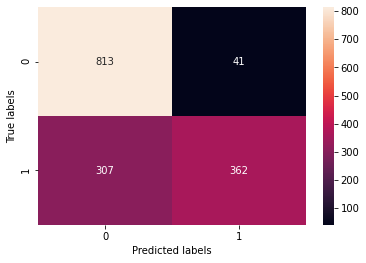

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)
F1 Score : 0.565
              precision    recall  f1-score   support

           0       0.68      0.98      0.80       854
           1       0.95      0.40      0.56       669

    accuracy                           0.73      1523
   macro avg       0.81      0.69      0.68      1523
weighted avg       0.80      0.73      0.70      1523



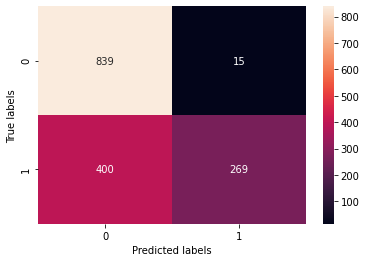

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
F1 Score : 0.581
              precision    recall  f1-score   support

           0       0.68      0.97      0.80       854
           1       0.92      0.42      0.58       669

    accuracy                           0.73      1523
   macro avg       0.80      0.70      0.69      1523
weighted avg       0.79      0.73      0.70      1523



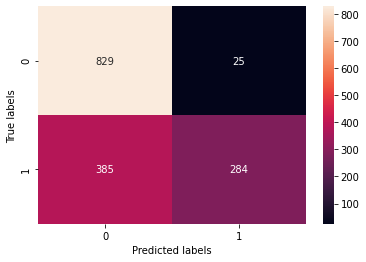

NuSVC(break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
      decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
      max_iter=-1, nu=0.5, probability=False, random_state=None, shrinking=True,
      tol=0.001, verbose=False)
F1 Score : 0.663
              precision    recall  f1-score   support

           0       0.72      0.95      0.82       854
           1       0.90      0.53      0.66       669

    accuracy                           0.76      1523
   macro avg       0.81      0.74      0.74      1523
weighted avg       0.80      0.76      0.75      1523



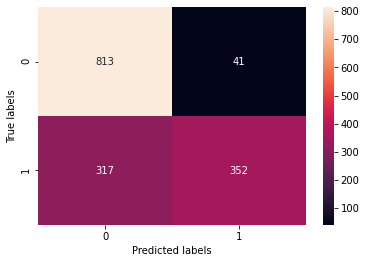

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
F1 Score : 0.725
              precision    recall  f1-score   support

           0       0.76      0.93      0.83       854
           1       0.87      0.62      0.73       669

    accuracy                           0.79      1523
   macro avg       0.81      0.77      0.78      1523
weighted avg       0.81      0.79      0.79      1523



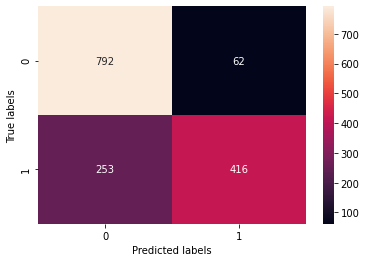

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
F1 Score : 0.625
              precision    recall  f1-score   support

           0       0.70      0.96      0.81       854
           1       0.91      0.48      0.63       669

    accuracy                           0.75      1523
   macro avg       0.81      0.72      0.72      1523
weighted avg       0.79      0.75      0.73      1523



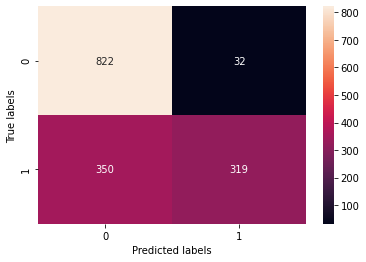

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
F1 Score : 0.608
              precision    recall  f1-score   support

           0       0.69      0.91      0.79       854
           1       0.81      0.49      0.61       669

    accuracy                           0.72      1523
   macro avg       0.75      0.70      0.70      1523
weighted avg       0.74      0.72      0.71      1523



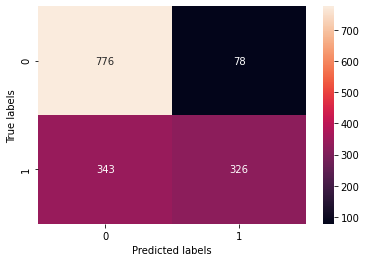

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
F1 Score : 0.631
              precision    recall  f1-score   support

           0       0.70      0.95      0.81       854
           1       0.89      0.49      0.63       669

    accuracy                           0.75      1523
   macro avg       0.80      0.72      0.72      1523
weighted avg       0.79      0.75      0.73      1523



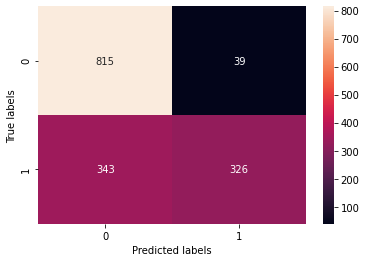

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
F1 Score : 0.645
              precision    recall  f1-score   support

           0       0.72      0.77      0.75       854
           1       0.68      0.61      0.64       669

    accuracy                           0.70      1523
   macro avg       0.70      0.69      0.69      1523
weighted avg       0.70      0.70      0.70      1523



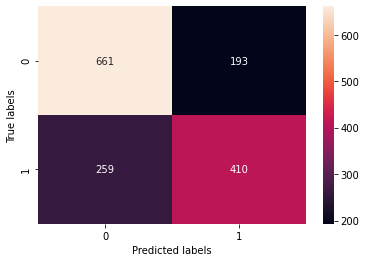

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
F1 Score : 0.680
              precision    recall  f1-score   support

           0       0.74      0.84      0.79       854
           1       0.76      0.62      0.68       669

    accuracy                           0.74      1523
   macro avg       0.75      0.73      0.73      1523
weighted avg       0.75      0.74      0.74      1523



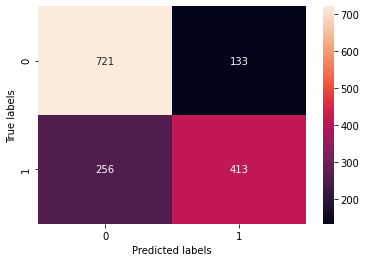

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
F1 Score : 0.634
              precision    recall  f1-score   support

           0       0.71      0.91      0.79       854
           1       0.81      0.52      0.63       669

    accuracy                           0.74      1523
   macro avg       0.76      0.71      0.71      1523
weighted avg  

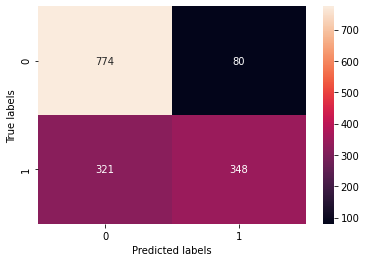

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)
F1 Score : 0.594
              precision    recall  f1-score   support

           0       0.69      0.91      0.78       854
           1       0.81      0.47      0.59       669

    accuracy                           0.72      1523
   macro avg       0.75      0.69      0.69      1523
weighted avg       0.74      0.72      0.70      1523



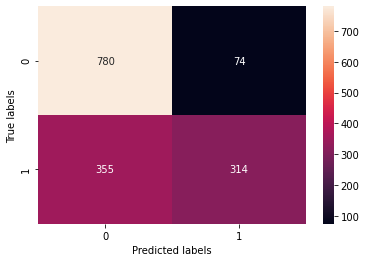

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)
F1 Score : 0.673
              precision    recall  f1-score   support

           0       0.73      0.94      0.82       854
           1       0.88      0.54      0.67       669

    accuracy                           0.77      1523
   macro avg       0.80      0.74      0.75      1523
weighted avg       0.79      0.77      0.76      1523



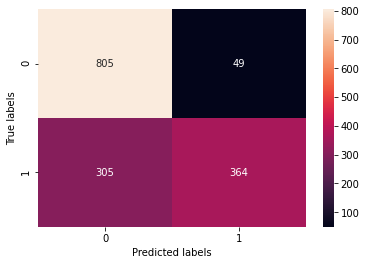

{'MNB': 0.6753731343283582, 'BNB': 0.5645330535152151, 'SVC': 0.5807770961145194, 'NuSVC': 0.6629001883239172, 'SGDC': 0.7253705318221447, 'LG': 0.6254901960784315, 'XGB': 0.6076421248835042, 'RF': 0.6305609284332688, 'DT': 0.6446540880503145, 'KN': 0.6798353909465021, 'GB': 0.6344576116681859, 'AB': 0.5941343424787134, 'ET': 0.6728280961182994}


In [0]:
# use pipeline 
all_f1_tnc = {}

for i in range(len(classifiers_tf)):
  pipe = Pipeline([('classifier', classifiers_tf[i])])
  pipe.fit(X_train, y_train)
  
  print(classifiers_tf[i])
  All_pred = pipe.predict(X_val)

  print('F1 Score : %.3f' %(f1_score(y_val, All_pred)))
  print(classification_report(y_val, All_pred))
  
  all_f1_tnc[name_tf[i]] = f1_score(y_val, All_pred)

  # do confusion matrix
  conf = confusion_matrix(y_val,All_pred)
  # show confusion matrix
  conf = pd.DataFrame(conf)
  sns.heatmap(conf, annot = True,fmt='')
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')
  plt.show()

print(all_f1_tnc)
  

   Classifier  F1 Score
0         BNB  0.564533
1         SVC  0.580777
2          AB  0.594134
3         XGB  0.607642
4          LG  0.625490
5          RF  0.630561
6          GB  0.634458
7          DT  0.644654
8       NuSVC  0.662900
9          ET  0.672828
10        MNB  0.675373
11         KN  0.679835
12       SGDC  0.725371


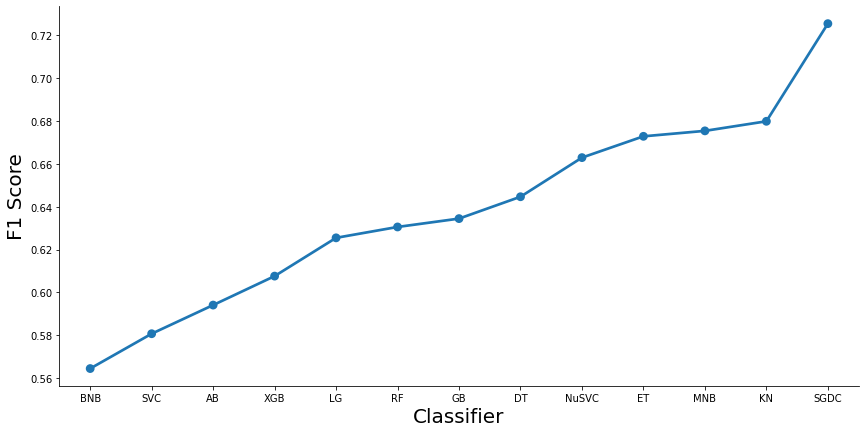

In [0]:
f1_sorted_tnc = sorted(all_f1_tnc.items(), key=lambda x: x[1], reverse=True)

pd_df = pd.DataFrame(f1_sorted_tnc)
pd_df.columns =["Classifier","F1 Score"]
# sort df by Count column
pd_df = pd_df.sort_values(['F1 Score']).reset_index(drop=True)
print(pd_df)

graph = sns.catplot(data=pd_df, x="Classifier", y="F1 Score", height=6, aspect=2, kind="point")
plt.ylabel('F1 Score', fontsize=20)
plt.xlabel('Classifier', fontsize=20)
plt.show()

#### WITH TF-iDF WITH CLEANING

In [0]:
X_train, X_val, y_train, y_val = train_test_split(vector_train_tf_c, train.target, test_size=0.2, random_state=2000)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
F1 Score : 0.675
              precision    recall  f1-score   support

           0       0.73      0.95      0.82       854
           1       0.90      0.54      0.68       669

    accuracy                           0.77      1523
   macro avg       0.81      0.75      0.75      1523
weighted avg       0.80      0.77      0.76      1523



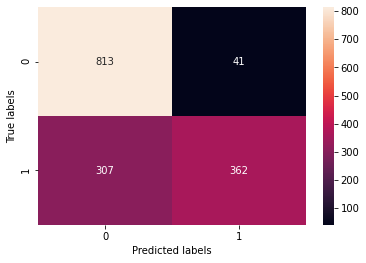

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)
F1 Score : 0.565
              precision    recall  f1-score   support

           0       0.68      0.98      0.80       854
           1       0.95      0.40      0.56       669

    accuracy                           0.73      1523
   macro avg       0.81      0.69      0.68      1523
weighted avg       0.80      0.73      0.70      1523



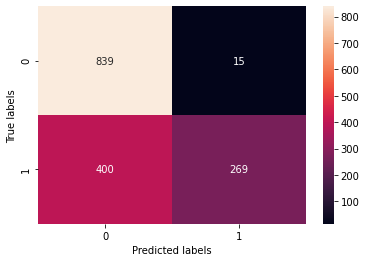

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
F1 Score : 0.581
              precision    recall  f1-score   support

           0       0.68      0.97      0.80       854
           1       0.92      0.42      0.58       669

    accuracy                           0.73      1523
   macro avg       0.80      0.70      0.69      1523
weighted avg       0.79      0.73      0.70      1523



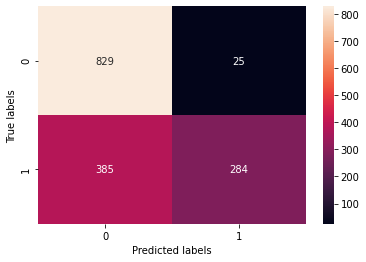

NuSVC(break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
      decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
      max_iter=-1, nu=0.5, probability=False, random_state=None, shrinking=True,
      tol=0.001, verbose=False)
F1 Score : 0.663
              precision    recall  f1-score   support

           0       0.72      0.95      0.82       854
           1       0.90      0.53      0.66       669

    accuracy                           0.76      1523
   macro avg       0.81      0.74      0.74      1523
weighted avg       0.80      0.76      0.75      1523



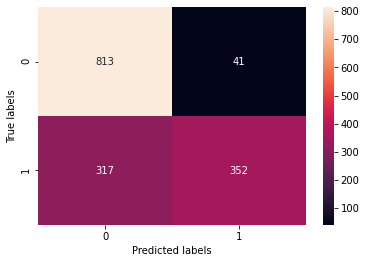

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
F1 Score : 0.726
              precision    recall  f1-score   support

           0       0.76      0.93      0.83       854
           1       0.87      0.62      0.73       669

    accuracy                           0.79      1523
   macro avg       0.81      0.78      0.78      1523
weighted avg       0.81      0.79      0.79      1523



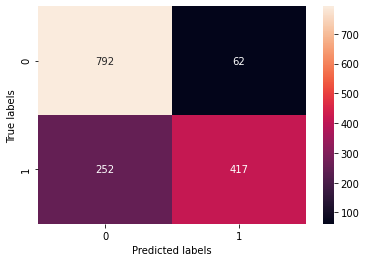

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
F1 Score : 0.625
              precision    recall  f1-score   support

           0       0.70      0.96      0.81       854
           1       0.91      0.48      0.63       669

    accuracy                           0.75      1523
   macro avg       0.81      0.72      0.72      1523
weighted avg       0.79      0.75      0.73      1523



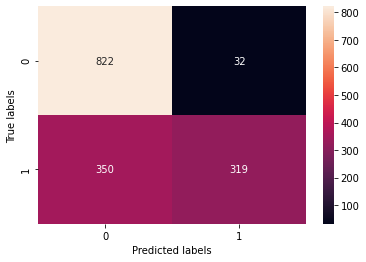

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
F1 Score : 0.608
              precision    recall  f1-score   support

           0       0.69      0.91      0.79       854
           1       0.81      0.49      0.61       669

    accuracy                           0.72      1523
   macro avg       0.75      0.70      0.70      1523
weighted avg       0.74      0.72      0.71      1523



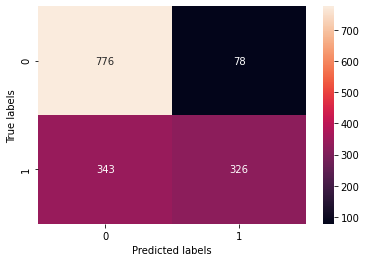

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
F1 Score : 0.644
              precision    recall  f1-score   support

           0       0.71      0.95      0.81       854
           1       0.89      0.51      0.64       669

    accuracy                           0.76      1523
   macro avg       0.80      0.73      0.73      1523
weighted avg       0.79      0.76      0.74      1523



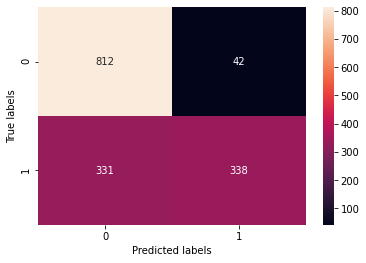

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
F1 Score : 0.642
              precision    recall  f1-score   support

           0       0.72      0.78      0.75       854
           1       0.69      0.60      0.64       669

    accuracy                           0.70      1523
   macro avg       0.70      0.69      0.70      1523
weighted avg       0.70      0.70      0.70      1523



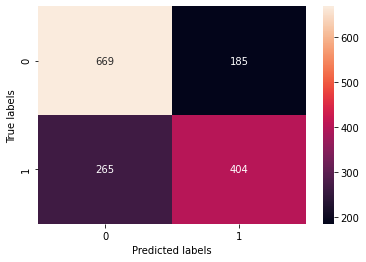

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
F1 Score : 0.680
              precision    recall  f1-score   support

           0       0.74      0.84      0.79       854
           1       0.76      0.62      0.68       669

    accuracy                           0.74      1523
   macro avg       0.75      0.73      0.73      1523
weighted avg       0.75      0.74      0.74      1523



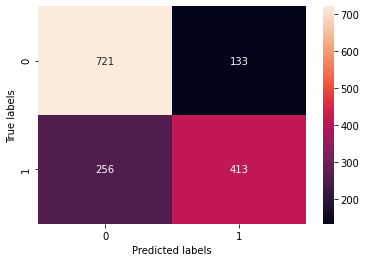

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
F1 Score : 0.630
              precision    recall  f1-score   support

           0       0.70      0.90      0.79       854
           1       0.81      0.52      0.63       669

    accuracy                           0.73      1523
   macro avg       0.76      0.71      0.71      1523
weighted avg  

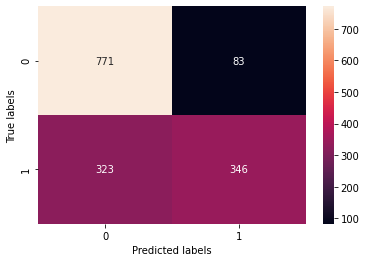

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)
F1 Score : 0.594
              precision    recall  f1-score   support

           0       0.69      0.91      0.78       854
           1       0.81      0.47      0.59       669

    accuracy                           0.72      1523
   macro avg       0.75      0.69      0.69      1523
weighted avg       0.74      0.72      0.70      1523



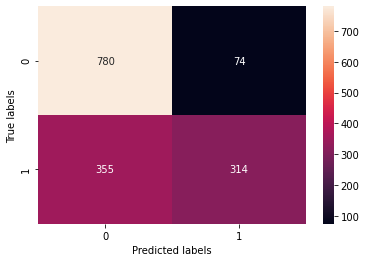

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)
F1 Score : 0.687
              precision    recall  f1-score   support

           0       0.73      0.94      0.82       854
           1       0.89      0.56      0.69       669

    accuracy                           0.78      1523
   macro avg       0.81      0.75      0.76      1523
weighted avg       0.80      0.78      0.76      1523



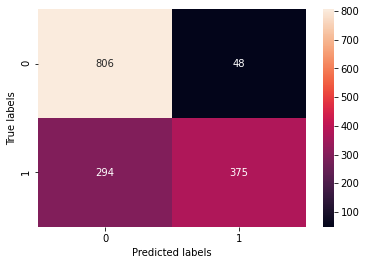

{'MNB': 0.6753731343283582, 'BNB': 0.5645330535152151, 'SVC': 0.5807770961145194, 'NuSVC': 0.6629001883239172, 'SGDC': 0.7264808362369339, 'LG': 0.6254901960784315, 'XGB': 0.6076421248835042, 'RF': 0.6444232602478551, 'DT': 0.6422893481717011, 'KN': 0.6798353909465021, 'GB': 0.6302367941712205, 'AB': 0.5941343424787134, 'ET': 0.6868131868131868}


In [0]:
# use pipeline 
all_f1_tc = {}

for i in range(len(classifiers_tf)):
  pipe = Pipeline([('classifier', classifiers_tf[i])])
  pipe.fit(X_train, y_train)
  
  print(classifiers_tf[i])
  All_pred = pipe.predict(X_val)

  print('F1 Score : %.3f' %(f1_score(y_val, All_pred)))
  print(classification_report(y_val, All_pred))
  
  all_f1_tc[name_tf[i]] = f1_score(y_val, All_pred)

  # do confusion matrix
  conf = confusion_matrix(y_val,All_pred)
  # show confusion matrix
  conf = pd.DataFrame(conf)
  sns.heatmap(conf, annot = True,fmt='')
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')
  plt.show()

print(all_f1_tc)

   Classifier  F1 Score
0         BNB  0.564533
1         SVC  0.580777
2          AB  0.594134
3         XGB  0.607642
4          LG  0.625490
5          GB  0.630237
6          DT  0.642289
7          RF  0.644423
8       NuSVC  0.662900
9         MNB  0.675373
10         KN  0.679835
11         ET  0.686813
12       SGDC  0.726481


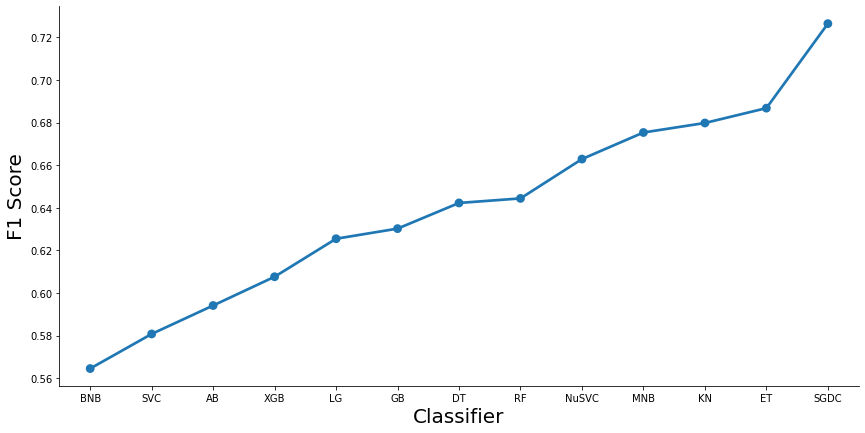

In [0]:
f1_sorted_tc = sorted(all_f1_tc.items(), key=lambda x: x[1], reverse=True)

pd_df = pd.DataFrame(f1_sorted_tc)
pd_df.columns =["Classifier","F1 Score"]
# sort df by Count column
pd_df = pd_df.sort_values(['F1 Score']).reset_index(drop=True)
print(pd_df)

graph = sns.catplot(data=pd_df, x="Classifier", y="F1 Score", height=6, aspect=2, kind="point")
plt.ylabel('F1 Score', fontsize=20)
plt.xlabel('Classifier', fontsize=20)
plt.show()

#### WITH TF-HUB WITHOUT CLEANING

In [0]:
X_train, X_val, y_train, y_val = train_test_split(vector_train_hub_nc, train.target, test_size=0.2, random_state=2000)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
F1 Score : 0.796
              precision    recall  f1-score   support

           0       0.81      0.92      0.86       854
           1       0.87      0.73      0.80       669

    accuracy                           0.84      1523
   macro avg       0.84      0.82      0.83      1523
weighted avg       0.84      0.84      0.83      1523



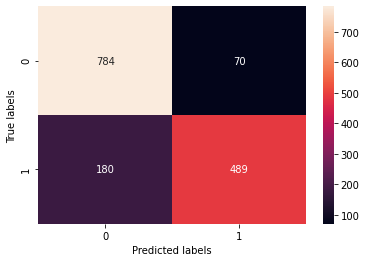

NuSVC(break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
      decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
      max_iter=-1, nu=0.5, probability=False, random_state=None, shrinking=True,
      tol=0.001, verbose=False)
F1 Score : 0.778
              precision    recall  f1-score   support

           0       0.79      0.93      0.86       854
           1       0.89      0.69      0.78       669

    accuracy                           0.83      1523
   macro avg       0.84      0.81      0.82      1523
weighted avg       0.83      0.83      0.82      1523



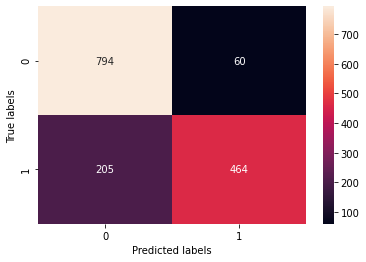

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
F1 Score : 0.778
              precision    recall  f1-score   support

           0       0.81      0.89      0.84       854
           1       0.83      0.73      0.78       669

    accuracy                           0.82      1523
   macro avg       0.82      0.81      0.81      1523
weighted avg       0.82      0.82      0.82      1523



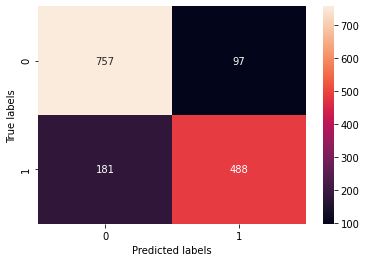

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
F1 Score : 0.783
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       854
           1       0.83      0.74      0.78       669

    accuracy                           0.82      1523
   macro avg       0.82      0.81      0.81      1523
weighted avg       0.82      0.82      0.82      1523



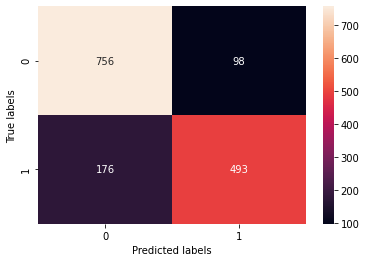

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
F1 Score : 0.734
              precision    recall  f1-score   support

           0       0.77      0.91      0.83       854
           1       0.85      0.64      0.73       669

    accuracy                           0.80      1523
   macro avg       0.81      0.78      0.78      1523
weighted avg       0.80      0.80      0.79      1523



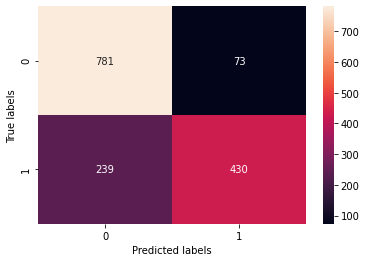

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
F1 Score : 0.674
              precision    recall  f1-score   support

           0       0.74      0.75      0.75       854
           1       0.68      0.67      0.67       669

    accuracy                           0.72      1523
   macro avg       0.71      0.71      0.71      1523
weighted avg       0.71      0.72      0.71      1523



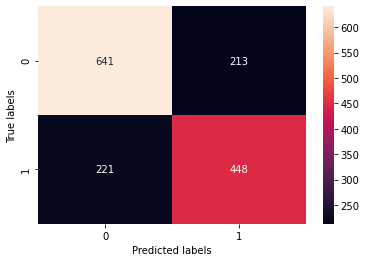

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
F1 Score : 0.775
              precision    recall  f1-score   support

           0       0.83      0.80      0.82       854
           1       0.76      0.79      0.78       669

    accuracy                           0.80      1523
   macro avg       0.80      0.80      0.80      1523
weighted avg       0.80      0.80      0.80      1523



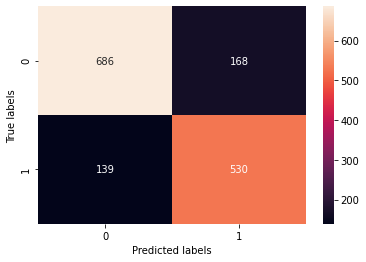

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
F1 Score : 0.772
              precision    recall  f1-score   support

           0       0.80      0.90      0.85       854
           1       0.85      0.71      0.77       669

    accuracy                           0.82      1523
   macro avg       0.82      0.80      0.81      1523
weighted avg  

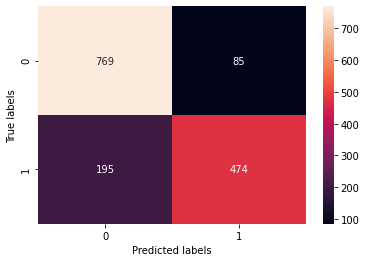

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)
F1 Score : 0.750
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       854
           1       0.76      0.74      0.75       669

    accuracy                           0.78      1523
   macro avg       0.78      0.78      0.78      1523
weighted avg       0.78      0.78      0.78      1523



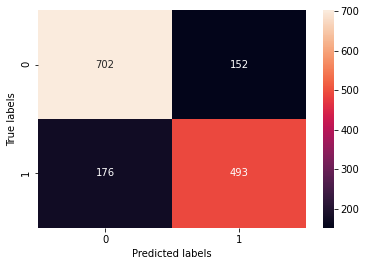

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)
F1 Score : 0.747
              precision    recall  f1-score   support

           0       0.77      0.92      0.84       854
           1       0.86      0.66      0.75       669

    accuracy                           0.80      1523
   macro avg       0.82      0.79      0.79      1523
weighted avg       0.81      0.80      0.80      1523



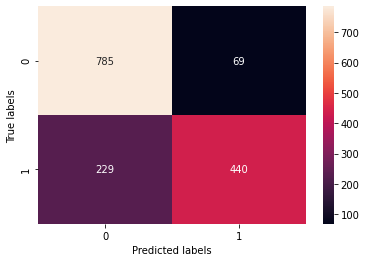

{'SVC': 0.7964169381107491, 'NuSVC': 0.7778709136630344, 'SGDC': 0.7783094098883572, 'LG': 0.7825396825396825, 'RF': 0.7337883959044369, 'DT': 0.6736842105263158, 'KN': 0.77542062911485, 'GB': 0.7719869706840391, 'AB': 0.7503805175038051, 'ET': 0.7470288624787778}


In [0]:
# use pipeline 
all_f1_hnc = {}

for i in range(len(classifiers_hub)):
  pipe = Pipeline([('classifier', classifiers_hub[i])])
  pipe.fit(X_train, y_train)
  
  print(classifiers_hub[i])
  All_pred = pipe.predict(X_val)

  print('F1 Score : %.3f' %(f1_score(y_val, All_pred)))
  print(classification_report(y_val, All_pred))
  
  all_f1_hnc[name_hub[i]] = f1_score(y_val, All_pred)

  # do confusion matrix
  conf = confusion_matrix(y_val,All_pred)
  # show confusion matrix
  conf = pd.DataFrame(conf)
  sns.heatmap(conf, annot = True,fmt='')
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')
  plt.show()

print(all_f1_hnc)

  Classifier  F1 Score
0         DT  0.673684
1         RF  0.733788
2         ET  0.747029
3         AB  0.750381
4         GB  0.771987
5         KN  0.775421
6      NuSVC  0.777871
7       SGDC  0.778309
8         LG  0.782540
9        SVC  0.796417


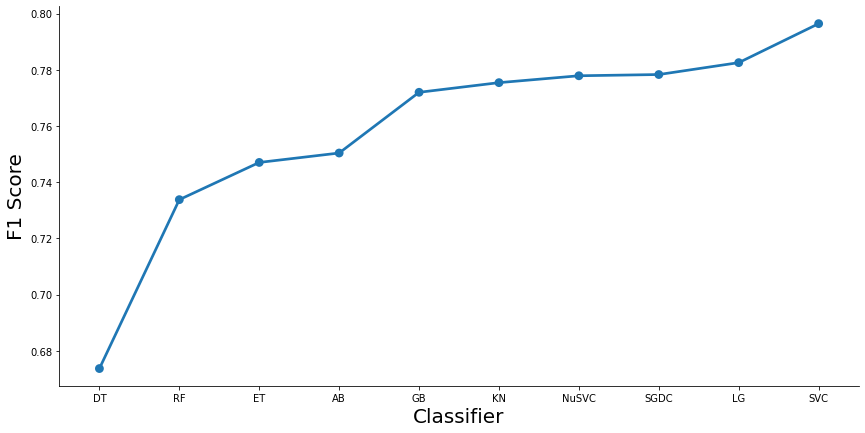

In [0]:
f1_sorted_hnc = sorted(all_f1_hnc.items(), key=lambda x: x[1], reverse=True)

pd_df = pd.DataFrame(f1_sorted_hnc)
pd_df.columns =["Classifier","F1 Score"]
# sort df by Count column
pd_df = pd_df.sort_values(['F1 Score']).reset_index(drop=True)
print(pd_df)

graph = sns.catplot(data=pd_df, x="Classifier", y="F1 Score", height=6, aspect=2, kind="point")
plt.ylabel('F1 Score', fontsize=20)
plt.xlabel('Classifier', fontsize=20)
plt.show()

#### With TF-HUB WITH CLEANING

In [0]:
X_train, X_val, y_train, y_val = train_test_split(vector_train_hub_c, train.target, test_size=0.2, random_state=2000)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
F1 Score : 0.796
              precision    recall  f1-score   support

           0       0.81      0.92      0.86       854
           1       0.87      0.73      0.80       669

    accuracy                           0.84      1523
   macro avg       0.84      0.82      0.83      1523
weighted avg       0.84      0.84      0.83      1523



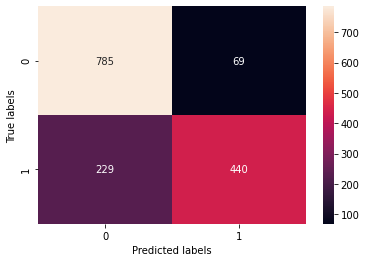

NuSVC(break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
      decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
      max_iter=-1, nu=0.5, probability=False, random_state=None, shrinking=True,
      tol=0.001, verbose=False)
F1 Score : 0.778
              precision    recall  f1-score   support

           0       0.79      0.93      0.86       854
           1       0.89      0.69      0.78       669

    accuracy                           0.83      1523
   macro avg       0.84      0.81      0.82      1523
weighted avg       0.83      0.83      0.82      1523



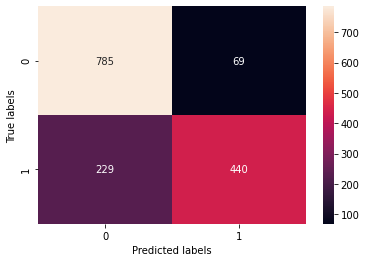

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
F1 Score : 0.787
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       854
           1       0.81      0.76      0.79       669

    accuracy                           0.82      1523
   macro avg       0.82      0.81      0.81      1523
weighted avg       0.82      0.82      0.82      1523



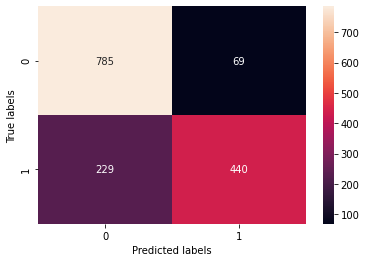

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
F1 Score : 0.783
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       854
           1       0.83      0.74      0.78       669

    accuracy                           0.82      1523
   macro avg       0.82      0.81      0.81      1523
weighted avg       0.82      0.82      0.82      1523



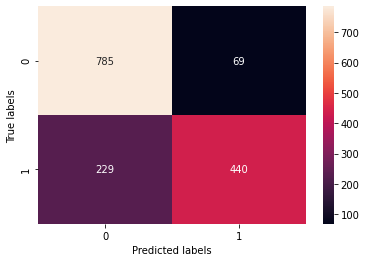

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
F1 Score : 0.746
              precision    recall  f1-score   support

           0       0.77      0.92      0.84       854
           1       0.86      0.66      0.75       669

    accuracy                           0.80      1523
   macro avg       0.82      0.79      0.79      1523
weighted avg       0.81      0.80      0.80      1523



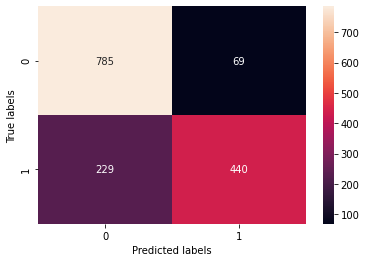

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
F1 Score : 0.672
              precision    recall  f1-score   support

           0       0.74      0.75      0.75       854
           1       0.68      0.67      0.67       669

    accuracy                           0.71      1523
   macro avg       0.71      0.71      0.71      1523
weighted avg       0.71      0.71      0.71      1523



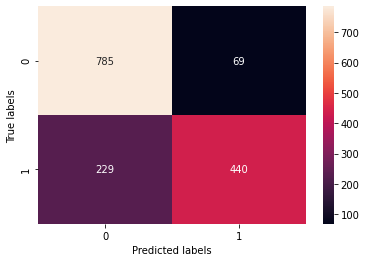

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
F1 Score : 0.775
              precision    recall  f1-score   support

           0       0.83      0.80      0.82       854
           1       0.76      0.79      0.78       669

    accuracy                           0.80      1523
   macro avg       0.80      0.80      0.80      1523
weighted avg       0.80      0.80      0.80      1523



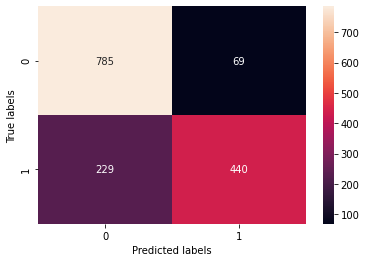

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
F1 Score : 0.772
              precision    recall  f1-score   support

           0       0.80      0.90      0.85       854
           1       0.85      0.71      0.77       669

    accuracy                           0.82      1523
   macro avg       0.82      0.80      0.81      1523
weighted avg  

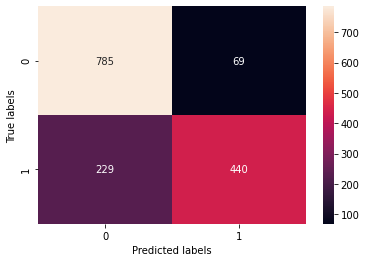

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)
F1 Score : 0.750
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       854
           1       0.76      0.74      0.75       669

    accuracy                           0.78      1523
   macro avg       0.78      0.78      0.78      1523
weighted avg       0.78      0.78      0.78      1523



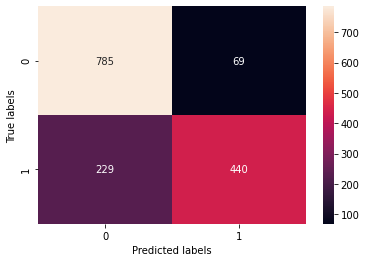

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)
F1 Score : 0.744
              precision    recall  f1-score   support

           0       0.77      0.93      0.84       854
           1       0.87      0.65      0.74       669

    accuracy                           0.80      1523
   macro avg       0.82      0.79      0.79      1523
weighted avg       0.81      0.80      0.80      1523



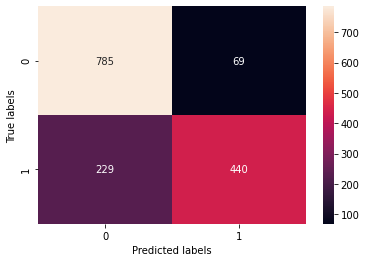

{'SVC': 0.7964169381107491, 'NuSVC': 0.7778709136630344, 'SGDC': 0.7867590454195534, 'LG': 0.7825396825396825, 'RF': 0.745964316057774, 'DT': 0.6721804511278195, 'KN': 0.77542062911485, 'GB': 0.7719869706840391, 'AB': 0.7503805175038051, 'ET': 0.7437874892887746}


In [0]:
# use pipeline 
all_f1_hc = {}
for i in range(len(classifiers_hub)):
  pipe = Pipeline([('classifier', classifiers_hub[i])])
  pipe.fit(X_train, y_train)

  print(classifiers_hub[i])
  All_pred = pipe.predict(X_val)

  print('F1 Score : %.3f' %(f1_score(y_val, All_pred)))
  print(classification_report(y_val, All_pred))
  
  all_f1_hc[name_hub[i]] = f1_score(y_val, All_pred)

  # do confusion matrix
  conf_bis = confusion_matrix(y_val,All_pred)
  # show confusion matrix
  conf_bis = pd.DataFrame(conf)
  sns.heatmap(conf, annot = True,fmt='')
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')
  plt.show()

print(all_f1_hc)

  Classifier  F1 Score
0         DT  0.672180
1         ET  0.743787
2         RF  0.745964
3         AB  0.750381
4         GB  0.771987
5         KN  0.775421
6      NuSVC  0.777871
7         LG  0.782540
8       SGDC  0.786759
9        SVC  0.796417


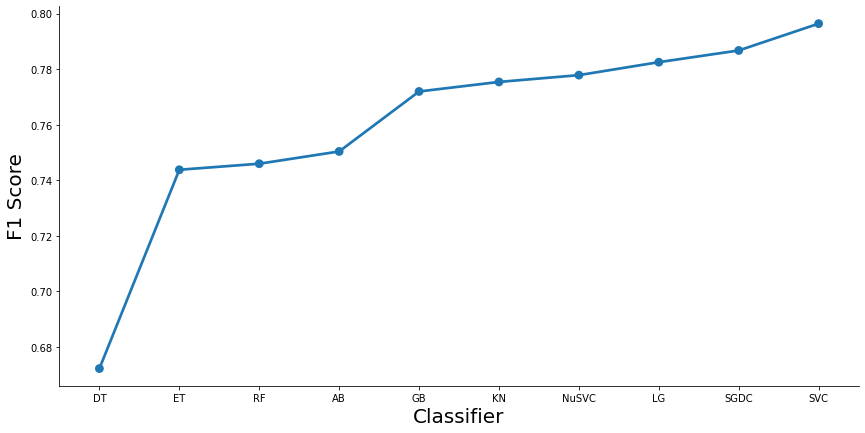

In [0]:
f1_sorted_hc = sorted(all_f1_hc.items(), key=lambda x: x[1], reverse=True)

pd_df = pd.DataFrame(f1_sorted_hc)
pd_df.columns =["Classifier","F1 Score"]
# sort df by Count column
pd_df = pd_df.sort_values(['F1 Score']).reset_index(drop=True)
print(pd_df)

graph = sns.catplot(data=pd_df, x="Classifier", y="F1 Score", height=6, aspect=2, kind="point")
plt.ylabel('F1 Score', fontsize=20)
plt.xlabel('Classifier', fontsize=20)
plt.show()



In the following section, we will try to use two good rated  classifiers for 
predicting "target = 1" and "target = 0", respectively SGDC and SVC. 

### Creating our All-in-One Simple Model


#### With TFHUB and no cleaning

In order to combine multiple classifiers, we will use the  voting classifier. Then, we will try to fine-tune the hyperparameters and weights to build a better model. 

Let's first try "voting hard". 


In [0]:
X_train, X_val, y_train, y_val = train_test_split(vector_train_hub_nc, train.target, test_size=0.2, random_state=2000)

In [0]:
# define classifiers
SGDBC_clf = SGDClassifier()
SVC_clf = SVC()

# use voting classifier
eclf = VotingClassifier(
    estimators=[('SGDBC', SGDBC_clf), ('SVC', SVC_clf)], voting='hard')

eclf.fit(X_train, y_train)
ECLF_pred = eclf.predict(X_val)
print('F1 Score : %.3f' %(f1_score(y_val, ECLF_pred)))



F1 Score : 0.789


Let's now try "voting soft". But we first need to find which loss parameter is the best for the SGDC classifier by using Grid Search CV. 

In [0]:
# ignore warnings
filterwarnings('ignore')

In [0]:
sgbc_param = {
 'loss': ["log", "modified_huber", "squared_hinge", "squared_loss", "huber", "squared_epsilon_insensitive"],
  'n_jobs': ["None", -1, 1]
 }

sgbc = SGDClassifier()
sgbc_clf = GridSearchCV(sgbc,sgbc_param)
sgbc_clf = sgbc_clf.fit(X_train, y_train)

for param_name in sorted(sgbc_param.keys()):
   print("%s: %r" % (param_name, sgbc_clf.best_params_[param_name]))

loss: 'log'
n_jobs: 1


So, we will use "modified_huber" as loss parameter. Now we can create our ensemble with Voting Classifier. We, will first try without the parameter weights. 

In [0]:
from sklearn.ensemble import VotingClassifier

svc_clf = SVC(probability = True)
score_svc = svc_clf.fit(X_train, y_train).score(X_val, y_val)

sgdc_clf = SGDClassifier(loss="log", n_jobs=1)
score_sgdc = sgdc_clf.fit(X_train, y_train).score(X_val, y_val)

Ensemble = VotingClassifier(estimators=[('SVC', svc_clf), ('SGDC', sgdc_clf)], voting='soft')

score_Ensemble = Ensemble.fit(X_train, y_train).score(X_val, y_val)

In [0]:
print(' Accuracy score : %.3f' %(score_Ensemble))

 Accuracy score : 0.833


Now, we will try to fine-tune the weights using Grid Search CV. 

In [0]:
# fine-tune weights
params = {'weights':[[0, 1], [1, 2], [1, 1], [2, 1], [1, 0],[0.5,1.5],[1.5,0.5],[0.2,0.8],[0.8,0.2]]}

grid = GridSearchCV(estimator=Ensemble, param_grid=params)

grid.fit(X_train,y_train)

print (grid.best_params_)


{'weights': [1, 0]}


In [0]:
Ensemble2 = VotingClassifier(estimators=[('SVC', svc_clf), ('SGDC', sgdc_clf)], voting='soft', weights= [1,2])

score_Ensemble2 = Ensemble2.fit(X_train, y_train).score(X_val, y_val)

In [0]:
print(' Accuracy score : %.3f' %(score_Ensemble))

 Accuracy score : 0.833


Unfortunately having weights "1,0" doesn't change much the result...

## Experimenting different complex models 

### BERT 

In [0]:
#BEST Parameters for bert model
random_state_split = 20
learning_rate = 6e-6
valid = 0.2
epochs_num = 3
batch_size_num = 16

In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub

import tokenization

In [0]:
#official tokenization script created by the Google team
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [0]:
# Thanks to https://www.kaggle.com/xhlulu/disaster-nlp-keras-bert-using-tfhub
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [0]:
# Thanks to https://www.kaggle.com/xhlulu/disaster-nlp-keras-bert-using-tfhub
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    
    
    out = Dense(1, activation='sigmoid')(clf_output)
   

    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [0]:
train = pd.read_csv('https://raw.githubusercontent.com/rnaua/BSA2020_project2/master/train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/rnaua/BSA2020_project2/master/test.csv')

In [0]:
# Thanks to https://www.kaggle.com/xhlulu/disaster-nlp-keras-bert-using-tfhub
# Load tokenizer from the bert layer
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [0]:
# Thanks to https://www.kaggle.com/xhlulu/disaster-nlp-keras-bert-using-tfhub
# Encode the text into tokens, masks, and segment flags
train_input = bert_encode(train.text.values, tokenizer, max_len=160)
test_input = bert_encode(test.text.values, tokenizer, max_len=160)
train_labels = train.target.values

In [0]:
# Thanks to https://www.kaggle.com/xhlulu/disaster-nlp-keras-bert-using-tfhub
# Build BERT model 
model_BERT = build_model(bert_layer, max_len=160)
model_BERT.summary()

In [0]:
# Thanks to https://www.kaggle.com/xhlulu/disaster-nlp-keras-bert-using-tfhub
# Train BERT model 
checkpoint = ModelCheckpoint('model_BERT.h5', monitor='val_loss', save_best_only=True)

train_history = model_BERT.fit(
    train_input, train_labels,
    validation_split = valid,
    epochs = epochs_num, # recomended 3-5 epochs
    callbacks=[checkpoint],
    batch_size = batch_size_num
)

### Logistic Regression

We, will first use GridSearchCV to "search over specified parameter values for an estimator". Then, we will plot the confusion matrix of our logist regression. 

In [0]:
parameter = {'solver':['liblinear','lbfgs'],
            'max_iter':[1000,2000]}
# define classifier
LOG_clf = LogisticRegression()

 # train the model on training subset
lreg = GridSearchCV(LOG_clf, param_grid = parameter, verbose=True,n_jobs= -1 )
X_train, X_val, y_train, y_val = train_test_split(vector_train, train.target, test_size=0.2, random_state=2000)

# fit with vectorizer
lreg.fit(X_train, y_train)

# predict on the validation subset
prediction = lreg.predict_proba(X_val)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    9.6s finished


In [0]:
prediction_int = prediction[:,1] >= 0.35
prediction_int = prediction_int.astype(np.int)
f1score = f1_score(y_val,prediction_int)
print('F1 Score : %.3f' %(f1score))


F1 Score : 0.782


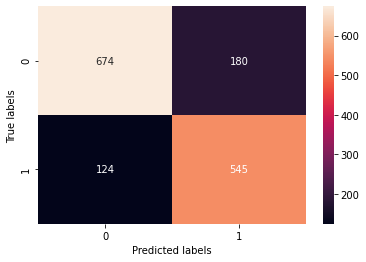

In [0]:
# do confusion matrix
conf = confusion_matrix(y_val,prediction_int)
# show confusion matrix
conf = pd.DataFrame(conf)
sns.heatmap(conf, annot = True,fmt='')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

-> So, we have 674+545 correct predictions and 180+124 incorrect predictions.

Now, we will try to use another function for logistic regression and see the corresponding confusion matrix. 

In [0]:
# define classifier
LOGCV_clf = LogisticRegressionCV(solver="lbfgs", cv=3, max_iter=1000)
# fit with vectorizer
LOGCV_clf.fit(X_train_tv, y_train)

# predict validation subset results and accuracy
LOGCV_pred = LOGCV_clf.predict(X_val_tv)

# see accuracy
print('F1 Score : %.3f' %(f1_score(y_val, LOGCV_pred)))
print('Accuracy Score : %.3f' %(accuracy_score(y_val, LOGCV_pred)))
print(classification_report(y_val, LOGCV_pred))

F1 Score : 0.743
Accuracy Score : 0.793
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       886
           1       0.77      0.72      0.74       637

    accuracy                           0.79      1523
   macro avg       0.79      0.78      0.78      1523
weighted avg       0.79      0.79      0.79      1523



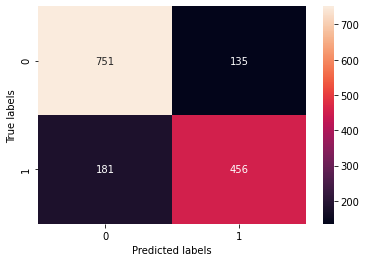

In [0]:
# do confusion matrix
conf = confusion_matrix(y_val,LOGCV_pred)
# show confusion matrix
conf = pd.DataFrame(conf)
sns.heatmap(conf, annot = True,fmt='')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

-> We can see that this function give us better results. 

# Submitting our results

In [0]:
# submission code
y_pred = Ensemble.predict(vector_test_hub_nc)

submission.target = y_pred
submission.to_csv('submission_ensemble_hub_nc_soft.csv', index = False)
files.download('submission_ensemble_hub_nc_soft.csv')

Below, are the different submissions we made on Kaggle.


1 : Randomforest classifier with cleaning and tf-idf vectorization -> 0.76584

2 : Error with own model -> 0.0

3 : Randomforest classifier without cleaning and Google universal encoder -> 0.79141

4 : SGDBC classifier with cleaning and Google universal encoder -> 0.79243

5 : Randomforest classifier with cleaning and Google universal encoder -> 0.75971 (seems like that cleaning does not help)

6 : SVM classifier with cleaning and google universal encoder -> 0.79856 

7 : SVM classifier without cleaning and google universal encoder -> 0.82515 (cleaning doesn't help at all !!)

8 : BERT without cleaning and specific bert encoder -> 0.82515

*   learning_rate = 4e-5
*   validation_split = 0.2
*   epochs_num = 4
*   batch_size = 32


9 : BERT Whitout cleaning and specific bert encoder -> 0.85480

*   learning_rate = 6e-6
*   validation_split = 0.2
*   epochs_num = 3
*   batch_size = 16

10: Voting Classifier with TFIDF only - > 0.77
11: Voting Classifier with TFIF only - > 0.77 

* n_jobs = -1
* loss = "modified_huber"
*  weights = [1,1]

11. Voting Classifier soft with TFHUB and no cleaning -> 0.81083

* loss = 'log'
* n_jobs = 1
* submission on vector_test_hub_nc



# Ranking in Kaggle competition

Rank: 103 -- Team Name: UNIL_Swatch -- Score: 0.85480 -- Entries: 11

# References

- https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection

- https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

- https://scikit-learn.org/stable/modules/ensemble.html#voting-classifier

- https://www.kaggle.com/vbmokin/nlp-eda-bag-of-words-tf-idf-glove-bert

- https://sebastianraschka.com/Articles/2014_ensemble_classifier.html

- https://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html